# Mean and Covariance Functions

A large set of mean and covariance functions are available in PyMC3.  It is relatively easy to define custom mean and covariance functions.  Since PyMC3 uses Theano, their gradients do not need to be defined by the user.  

## Mean functions

The following mean functions are available in PyMC3.

- `gp.mean.Zero`
- `gp.mean.Constant`
- `gp.mean.Linear`

All follow a similar usage pattern.  First, the mean function is specified.  Then it can be evaluated over some inputs.  The first two mean functions are very simple.  Regardless of the inputs, `gp.mean.Zero` returns a vector of zeros with the same length as the number of input values.

### Zero

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
%matplotlib inline

import numpy as np
np.random.seed(206)

import theano
import theano.tensor as tt
import pymc3 as pm

In [2]:
zero_func = pm.gp.mean.Zero()

X = np.linspace(0, 1, 5)[:, None]
print(zero_func(X).eval())

[ 0.  0.  0.  0.  0.]


The default mean functions for all GP implementations in PyMC3 is `Zero`.

### Constant

`gp.mean.Constant` returns a vector whose value is provided.

In [3]:
const_func = pm.gp.mean.Constant(25.2)

print(const_func(X).eval())

[ 25.2  25.2  25.2  25.2  25.2]


As long as the shape matches the input it will receive, `gp.mean.Constant` can also accept a Theano tensor or vector of PyMC3 random variables.

In [4]:
const_func_vec = pm.gp.mean.Constant(tt.ones(5))

print(const_func_vec(X).eval())

[ 1.  1.  1.  1.  1.]


### Linear

`gp.mean.Linear` is a takes as input a matrix of coefficients and a vector of intercepts (or a slope and scalar intercept in one dimension).

In [5]:
beta = np.random.randn(3)
b = 0.0

lin_func = pm.gp.mean.Linear(coeffs=beta, intercept=b)

X = np.random.randn(5, 3)
print(lin_func(X).eval())

[-0.36242716  2.20718024  0.41039522  2.50735445 -2.06177178]


A common default parameterization for GPs is a zero mean function. This is not a strong constraint because a zero-mean prior process does not confine the posterior process to be zero. 

For reasons related to interpretability and the expression of prior information, one might want to model a more complex mean function.

## Defining a custom mean function

To define a custom mean function, subclass `gp.mean.Mean`, and provide `__call__` and `__init__` methods.  For example, the code for the `Constant` mean function is

```python
import theano.tensor as tt

class Constant(pm.gp.mean.Mean):
    
    def __init__(self, c=0):
        Mean.__init__(self)
        self.c = c 

    def __call__(self, X): 
        return tt.alloc(1.0, X.shape[0]) * self.c

```

Remember that Theano must be used instead of NumPy.

### Exercise

Create a custom mean function for a polynomial mean. Try drawing samples from a cubic mean function.

In [6]:
# Write your answer here

## Covariance functions

The behavior of individual realizations from the GP is governed by the covariance function. This function controls both the degree of *shrinkage* to the mean function and the *smoothness* of functions sampled from the GP.

PyMC3 includes a large library of covariance functions to choose from. A flexible choice to start with is the Mat&#232;rn covariance. 

$$k_{M}(x, x') = \frac{\sigma^2}{\Gamma(\nu)2^{\nu-1}} \left(\frac{\sqrt{2 \nu} (x - x')}{l}\right)^{\nu} K_{\nu}\left(\frac{\sqrt{2 \nu} (x - x')}{l}\right)$$

where where $\Gamma$ is the gamma function and $K$ is a modified Bessel function. The form of covariance matrices sampled from this function is governed by three parameters, each of which controls a property of the covariance.

* **amplitude** ($\sigma$) controls the scaling of the output along the y-axis. This parameter is just a scalar multiplier, and is therefore usually left out of implementations of the Mat&#232;rn function (*i.e.* set to one)

* **lengthscale** ($l$) complements the amplitude by scaling realizations on the x-axis. Larger values make points appear closer together.

* **roughness** ($\nu$) controls the sharpness of ridges in the covariance function, which ultimately affect the roughness (smoothness) of realizations.

Though in general all the parameters are non-negative real-valued, when $\nu = p + 1/2$ for integer-valued $p$, the function can be expressed partly as a polynomial function of order $p$ and generates realizations that are $p$-times differentiable, so values $\nu \in \{3/2, 5/2\}$ are extremely common.

The following shows functions drawn from a GP prior with a given covariance function, and demonstrates how composite covariance functions can be constructed with Python operators in a straightforward manner.  Our goal was for our API to follow kernel algebra (see Ch.4 of Rassmussen + Williams) as closely as possible.  

### Matern 5/2

Setting $\nu=5/2$ results in a simplified form for the Matern covariance function:


$$
k(x, x') = \left(1 + \frac{\sqrt{5(x - x')^2}}{\ell} +
            \frac{5(x-x')^2}{3\ell^2}\right)
            \mathrm{exp}\left[ - \frac{\sqrt{5(x - x')^2}}{\ell} \right]
$$

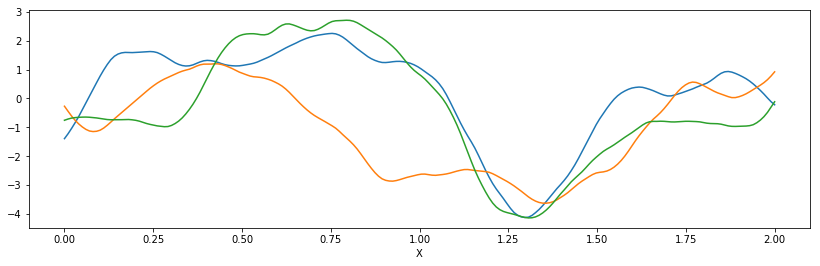

In [7]:
ls = 0.2
tau = 2.0
cov = tau * pm.gp.cov.Matern52(1, ls)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.xlabel("X");

### Matern 3/2

$$
k(x, x') = \left(1 + \frac{\sqrt{3(x - x')^2}}{\ell}\right)
           \mathrm{exp}\left[ - \frac{\sqrt{3(x - x')^2}}{\ell} \right]
$$

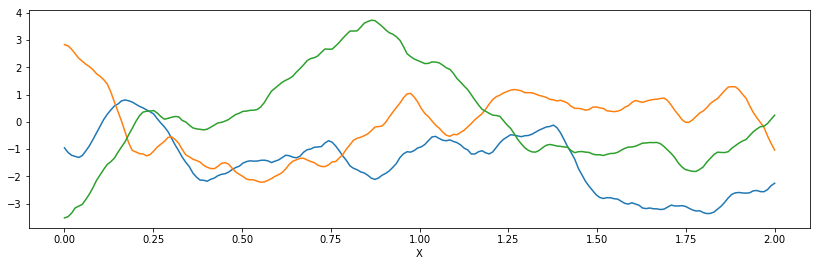

In [8]:
ls = 0.2
tau = 2.0
cov = tau * pm.gp.cov.Matern32(1, ls)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.xlabel("X");

### Exponentiated Quadratic

$$
k(x, x') = \mathrm{exp}\left[ -\frac{(x - x')^2}{2 \ell^2} \right]
$$

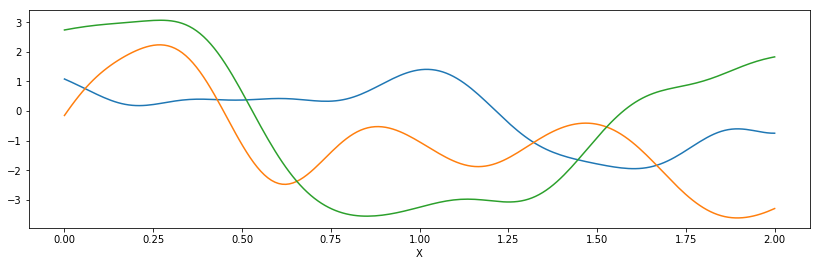

In [9]:
lengthscale = 0.2 
eta = 2.0
cov = eta**2 * pm.gp.cov.ExpQuad(1, lengthscale)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.xlabel("X");

### White Noise

$$
k(x, x') = \sigma^2 \mathrm{I}_{xx}
$$

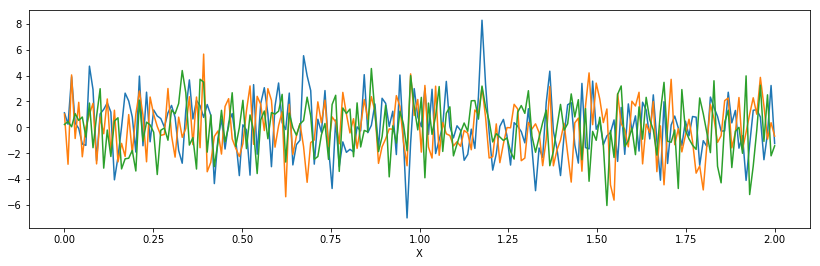

In [10]:
sigma = 2.0
cov = pm.gp.cov.WhiteNoise(sigma)
    
X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.xlabel("X");

### Constant

$$
k(x, x') = c
$$

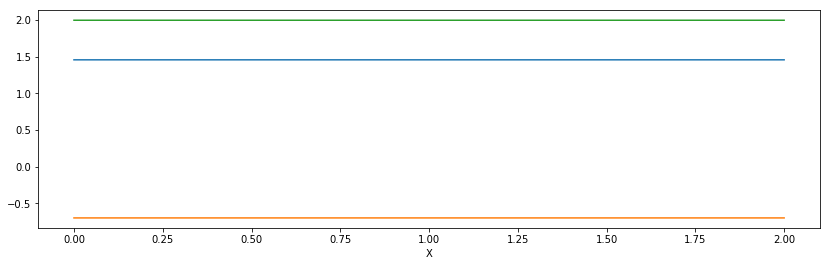

In [11]:
c = 2.0
cov = pm.gp.cov.Constant(c)
    
X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.xlabel("X");

### Rational Quadratic

$$
k(x, x') = \left(1 + \frac{(x - x')^2}{2\alpha\ell^2} \right)^{-\alpha}
$$

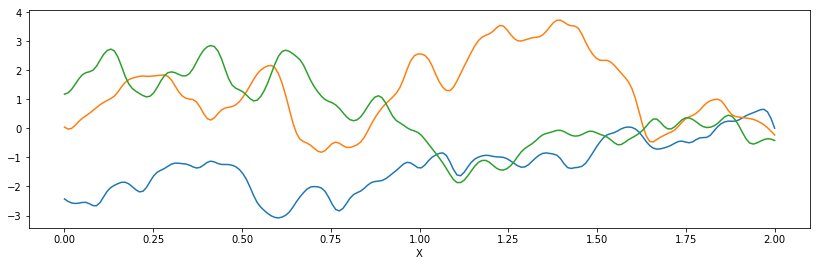

In [12]:
alpha = 0.1
ls = 0.2
tau = 2.0
cov = tau * pm.gp.cov.RatQuad(1, ls, alpha)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.xlabel("X");

### Exponential

$$
k(x, x') = \mathrm{exp}\left[ -\frac{||x - x'||}{2\ell^2} \right]
$$

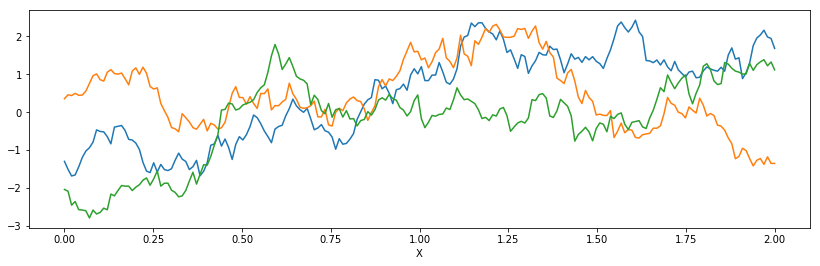

In [13]:
inverse_lengthscale = 5
cov = pm.gp.cov.Exponential(1, ls_inv=inverse_lengthscale)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.xlabel("X");

### Cosine

$$
k(x, x') = \mathrm{cos}\left( 2 \pi \frac{||x - x'||}{ \ell^2} \right)
$$

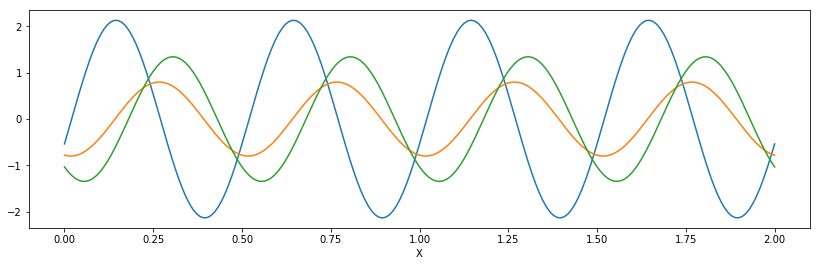

In [14]:
period = 0.5
cov = pm.gp.cov.Cosine(1, period)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.xlabel("X");

### Linear

$$
k(x, x') = (x - c)(x' - c)
$$

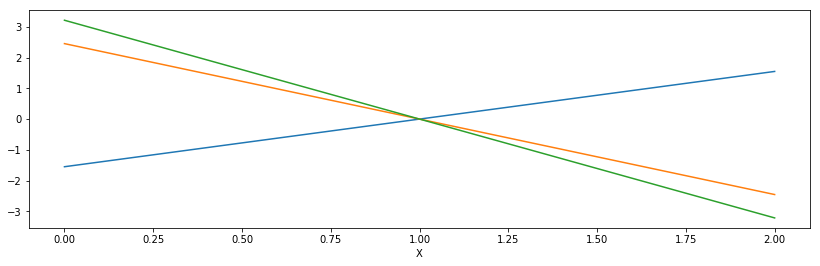

In [15]:
c = 1.0
tau = 2.0
cov = tau * pm.gp.cov.Linear(1, c)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.xlabel("X");

### Polynomial

$$
k(x, x') = [(x - c)(x' - c) + \mathrm{offset}]^{d}
$$

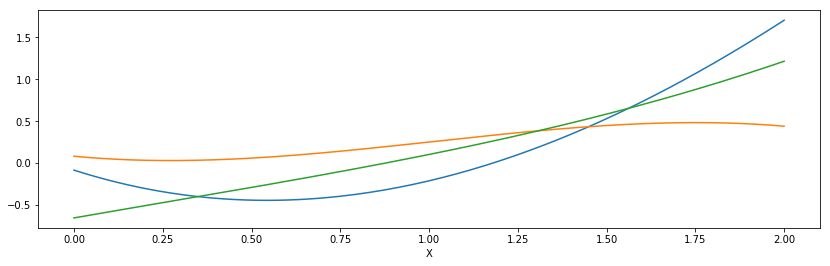

In [16]:
c = 1.0
d = 3
offset = 1.0
tau = 0.1
cov = tau * pm.gp.cov.Polynomial(1, c=c, d=d, offset=offset)

X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.xlabel("X");

### Multiplication with a precomputed covariance matrix

A covariance function ```cov``` can be multiplied with numpy matrix, ```K_cos```, as long as the shapes are appropriate.

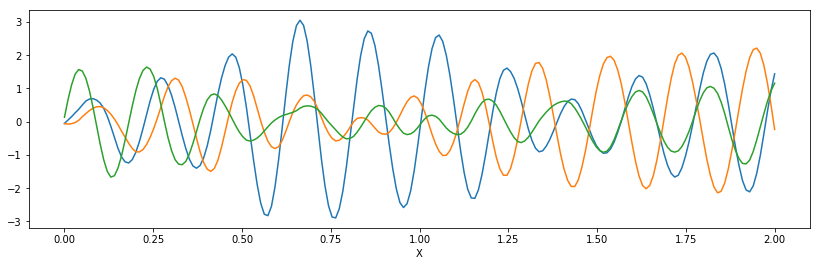

In [17]:
# first evaluate a covariance function into a matrix
period = 0.2
cov_cos = pm.gp.cov.Cosine(1, period)
K_cos = theano.function([], cov_cos(X))()

# now multiply it with a covariance *function* 
cov = pm.gp.cov.Matern32(1, 0.5) * K_cos
    
X = np.linspace(0, 2, 200)[:,None]
K = cov(X).eval()

plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.xlabel("X");

### Applying an arbitary warping function on the inputs

If $k(x, x')$ is a valid covariance function, then so is $k(w(x), w(x'))$.

The first argument of the warping function must be the input ```X```.  The remaining arguments can be anything else, including random variables.  

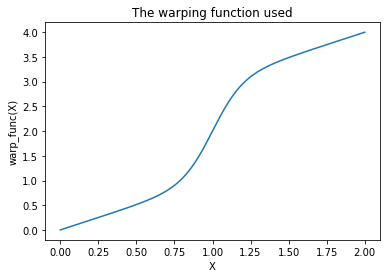

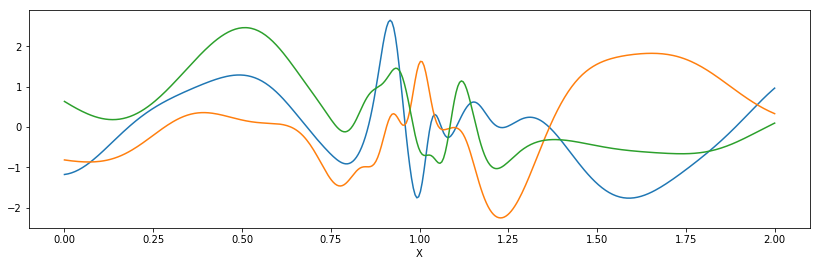

In [18]:
def warp_func(x, a, b, c):
    return 1.0 + x + (a * tt.tanh(b * (x - c)))

a = 1.0
b = 5.0
c = 1.0

cov_m52 = pm.gp.cov.ExpQuad(1, 0.2)
cov = pm.gp.cov.WarpedInput(1, warp_func=warp_func, args=(a,b,c), cov_func=cov_m52)

X = np.linspace(0, 2, 400)[:,None]
wf = theano.function([], warp_func(X.flatten(), a,b,c))()
plt.plot(X, wf); plt.xlabel("X"); plt.ylabel("warp_func(X)"); 
plt.title("The warping function used");

K = cov(X).eval()
plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.xlabel("X");

### Constructing `Periodic` using `WarpedInput`

The `WarpedInput` kernel can be used to create the `Periodic` covariance.  This covariance models functions that are periodic, but are not an exact sine wave (like the `Cosine` kernel is).

The periodic kernel is given by

$$
k(x, x') = \exp\left( -\frac{2 \sin^{2}(\pi |x - x'|\frac{1}{T})}{\ell^2}     \right)
$$

Where T is the period, and $\ell$ is the lengthscale.  It can be derived by warping the input of an `ExpQuad` kernel with the function $\mathbf{u}(x) = (\sin(2\pi x \frac{1}{T})\,, \cos(2 \pi x \frac{1}{T}))$.  Here we use the `WarpedInput` kernel to construct it.

The input `X`, which is defined at the top of this page, is 2 "seconds" long.  We use a period of $0.5$, which means that functions
drawn from this GP prior will repeat 4 times over 2 seconds.  

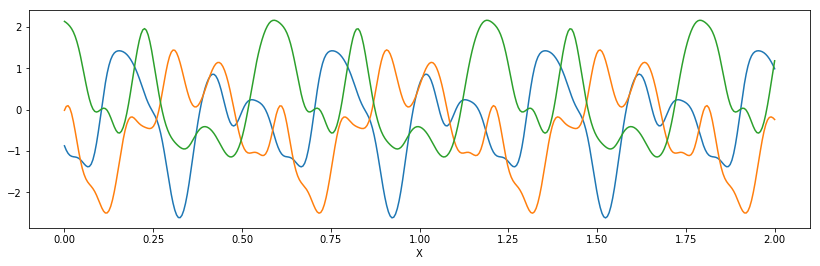

In [19]:
def mapping(x, T):
    c = 2.0 * np.pi * (1.0 / T)
    u = tt.concatenate((tt.sin(c*x), tt.cos(c*x)), 1)
    return u

T = 0.6
ls = 0.4
# note that the input of the covariance function taking 
#    the inputs is 2 dimensional 
cov_exp = pm.gp.cov.ExpQuad(2, ls)  
cov = pm.gp.cov.WarpedInput(1, cov_func=cov_exp, 
                               warp_func=mapping, args=(T, ))

K = cov(X).eval()
plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.xlabel("X");

### Periodic

There is no need to construct the periodic covariance this way every time.  A more efficient implementation of this covariance function is built in.

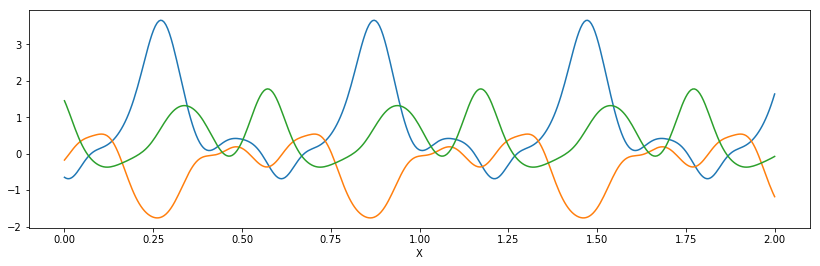

In [20]:
period = 0.6
ls = 0.4
cov = pm.gp.cov.Periodic(1, period=period, ls=ls) 

K = cov(X).eval()
plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.xlabel("X");

### Gibbs

The Gibbs covariance function applies a positive definite warping function to the lengthscale.  Similarly to ```WarpedInput```, the lengthscale warping function can be specified with parameters that are either fixed or random variables.

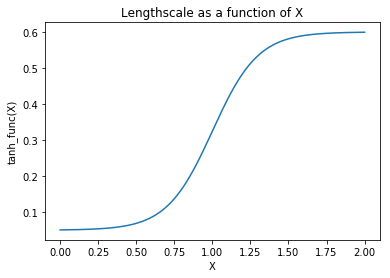

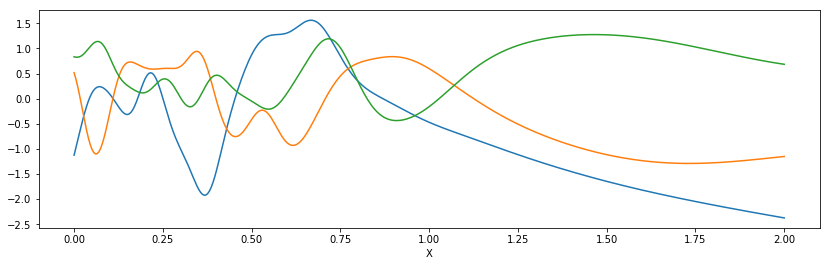

In [21]:
def tanh_func(x, ls1, ls2, w, x0):
    """
    ls1: left saturation value
    ls2: right saturation value
    w:   transition width
    x0:  transition location.
    """
    return (ls1 + ls2) / 2.0 - (ls1 - ls2) / 2.0 * tt.tanh((x - x0) / w)

ls1 = 0.05
ls2 = 0.6
w = 0.3
x0 = 1.0
cov = pm.gp.cov.Gibbs(1, tanh_func, args=(ls1, ls2, w, x0))
    
wf = theano.function([], tanh_func(X, ls1, ls2, w, x0))()
plt.plot(X, wf); plt.ylabel("tanh_func(X)"); plt.xlabel("X"); plt.title("Lengthscale as a function of X");

K = cov(X).eval()
plt.figure(figsize=(14,4))
plt.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.xlabel("X");

### Two (and higher) Dimensional Inputs

#### Both dimensions active

It is easy to define kernels with higher dimensional inputs.  Notice that the ```ls``` (lengthscale) parameter is an array of length 2.  Lists of PyMC3 random variables can be used for automatic relevance determination (ARD).

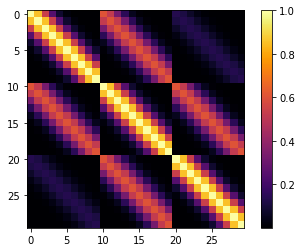

In [22]:
x1, x2 = np.meshgrid(np.linspace(0,1,10), np.arange(1,4))
X2 = np.concatenate((x1.reshape((30,1)), x2.reshape((30,1))), axis=1)

ls = np.array([0.2, 1.0])
cov = pm.gp.cov.ExpQuad(input_dim=2, ls=ls)

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation='none'); plt.colorbar(m);

#### One dimension active

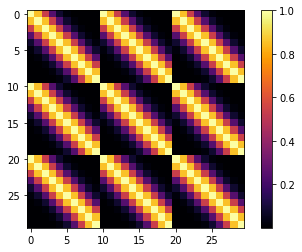

In [23]:
ls = 0.2
cov = pm.gp.cov.ExpQuad(input_dim=2, ls=ls, active_dims=[0])

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation='none'); plt.colorbar(m);

#### Product of covariances over different dimensions

Note that this is equivalent to using a two dimensional `ExpQuad` with separate lengthscale parameters for each dimension.

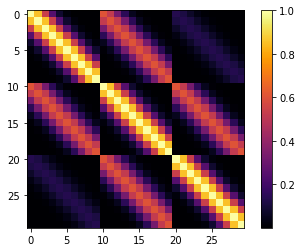

In [24]:
ls1 = 0.2
ls2 = 1.0
cov1 = pm.gp.cov.ExpQuad(2, ls1, active_dims=[0])
cov2 = pm.gp.cov.ExpQuad(2, ls2, active_dims=[1])
cov = cov1 * cov2

K = theano.function([], cov(X2))()
m = plt.imshow(K, cmap="inferno", interpolation='none'); plt.colorbar(m);

### Defining a custom covariance function

Covariance function objects in PyMC3 need to implement the `__init__`, `diag`, and `full` methods, and subclass `gp.cov.Covariance`.  `diag` returns only the diagonal of the covariance matrix, and `full` returns the full covariance matrix.  The `full` method has two inputs `X` and `Xs`.  `full(X)` returns the square covariance matrix, and `full(X, Xs)` returns the cross-covariances between the two sets of inputs.

For example, here is the implementation of the `WhiteNoise` covariance function:

```python
class WhiteNoise(pm.gp.cov.Covariance):
    def __init__(self, sigma):
        super(WhiteNoise, self).__init__(1, None)
        self.sigma = sigma

    def diag(self, X):
        return tt.alloc(tt.square(self.sigma), X.shape[0])

    def full(self, X, Xs=None):
        if Xs is None:
            return tt.diag(self.diag(X))
        else:
            return tt.alloc(0.0, X.shape[0], Xs.shape[0])
```